In [66]:
import os
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

from sklearn.preprocessing import StandardScaler

## **I. Preprocessing**

#### Data Import

In [12]:
MARKET_PATH = "data/market.csv"
MAP_PATH    = "data/map.csv"
README_PATH = "data/readme.rtf"

# Load returns table
market = pd.read_csv(MARKET_PATH)
df = market.copy()
market.head()

,MKT,SEC01,SEC02,SEC03,SEC04,SEC05,SEC06,SEC07,SEC08,SEC09,...,A091,A092,A093,A094,A095,A096,A097,A098,A099,A100
0,0.014778,0.013723,0.006033,0.012443,-0.006072,0.015750,0.020189,0.025308,0.016131,0.006779,...,0.019686,-0.003754,0.008045,0.039881,0.019591,0.002210,0.002275,0.004863,-0.006108,-0.005238
1,0.004882,0.015384,-0.001119,-0.003761,-0.000143,0.004392,0.009303,0.006761,0.007748,0.007224,...,0.036371,0.003600,0.028597,0.024576,0.012501,0.015962,0.043648,0.019679,0.028817,0.023622
2,-0.008071,-0.003830,-0.017498,-0.006121,-0.010113,-0.014196,-0.015075,-0.005636,-0.005795,-0.010602,...,0.013957,-0.007536,0.001469,-0.011205,0.010916,-0.006308,0.003379,-0.006914,-0.010737,0.001898
3,0.000945,0.019916,-0.014134,-0.006198,0.007958,0.012153,0.023033,-0.011556,0.003110,0.003062,...,-0.001098,0.006952,-0.006139,0.030582,0.001759,0.002405,0.017703,-0.000970,0.010676,-0.008408
4,0.001240,-0.006248,0.005246,-0.005167,-0.001875,0.001056,0.005933,-0.006497,0.008783,0.024005,...,0.009480,-0.006509,-0.009315,0.006255,-0.028752,-0.000977,0.007042,-0.018244,0.010732,0.002500


#### Preprocess : 
- remove sector data,
- train test split,
- center the vectors to simplify the covariance computation

In [231]:
# Keep asset data
cols = df.columns.tolist()
asset_cols = [c for c in cols if (not str(c).upper().startswith("SEC")) and (str(c).upper() != "MKT")]

X = df[asset_cols].astype(float).dropna()
X10 = df[asset_cols[:10]].astype(float).dropna()
print("Assets-only X shape:", X.shape)
print("First columns:", asset_cols[:10])

# Train, test split ; 80% train, 20% test
n = len(X)
n_train = int(0.8 * n)
n_val   = int(0.2 * n)

X_train_df = X.iloc[:n_train]
X_test_df  = X.iloc[n_train + n_val:]

# Center using training mean only
mu = X_train_df.mean(axis=0)
X_train = (X_train_df - mu).to_numpy()
X_test  = (X_test_df  - mu).to_numpy()

print("Train shape:", X_train.shape)
print("Test shape :", X_test.shape)

Assets-only X shape: (1000, 100)
First columns: ['A001', 'A002', 'A003', 'A004', 'A005', 'A006', 'A007', 'A008', 'A009', 'A010']
Train shape: (800, 100)
Test shape : (0, 100)


## **II. Model**: Graphical Lasso

In [ ]:

def empirical_cov(X):
    return np.cov(X, rowvar=False, bias=False)

S_train = empirical_cov(X_train)
S_test  = empirical_cov(X_test)

print("Shapes:", X_train.shape, X_val.shape, X_test.shape)


### **1. Graphial Lasso :** Coordinate subproblem and gradient descent

In [98]:
def soft_threshold(x: float, lam: float) -> float:
    if x > lam:
        return x - lam
    if x < -lam:
        return x + lam
    return 0.0

def solve_quadratic_lasso_cd(A, b, lam, max_iter=10_000, tol=1e-6):
    """
    Coordinate descent for:
        0.5 * w^T A w - b^T w + lam * ||w||_1
    where A is symmetric PSD (covariance submatrix).
    """
    m = b.shape[0]
    w = np.zeros(m)

    # Precompute diagonal (must be > 0 for stable updates)
    diag = np.diag(A).copy()
    if np.any(diag <= 1e-12):
        # tiny ridge for numerical stability
        A = A + 1e-10 * np.eye(m)
        diag = np.diag(A)

    for _ in range(max_iter):
        w_old = w.copy()

        # coordinate updates
        for j in range(m):
            # rho = b_j - sum_{k != j} A_{jk} w_k
            # compute using dot then add back diagonal term
            rho = b[j] - (A[j, :] @ w) + A[j, j] * w[j]
            w[j] = soft_threshold(rho, lam) / diag[j]

        # stopping criterion
        if np.max(np.abs(w - w_old)) < tol:
            break

    return w


def graphical_lasso_from_cov(S, lam, max_cd_iter=10_000, cd_tol=1e-6, jitter=1e-8):
    """
    Column-by-column estimation following the provided subproblem (using S blocks).
    Returns a symmetric precision matrix Theta.
    """
    p = S.shape[0]
    Theta = np.zeros((p, p), dtype=float)

    # small jitter for stability (covariance might be near-singular)
    S_stable = S + jitter * np.eye(p)

    for i in range(p):
        idx = np.arange(p) != i

        A = S_stable[np.ix_(idx, idx)]   # S_-i,-i
        b = S_stable[idx, i]             # S_-i,i

        beta = solve_quadratic_lasso_cd(A, b, lam, max_iter=max_cd_iter, tol=cd_tol)

        # Schur complement denominator: S_ii - b^T beta
        denom = S_stable[i, i] - b @ beta
        denom = max(denom, 1e-12)  # avoid divide by 0
        theta_ii = 1.0 / denom

        Theta[i, i] = theta_ii
        Theta[idx, i] = -beta * theta_ii

    # Symmetrize (simple & common for this per-column construction)
    Theta = 0.5 * (Theta + Theta.T)
    return Theta

### **2. Cross Validation Model** 

- gaussian likelihood based criterion for cross validation
- number of edges (based on non zeros $\theta_{i,j}$ )

In [139]:
def gaussian_nll_from_cov(S, Theta, jitter=1e-10):
    """
    Returns: -logdet(Theta) + tr(S Theta)
    (constants omitted; OK for comparing lambdas)
    """
    p = Theta.shape[0]
    Theta_stable = Theta + jitter * np.eye(p)

    sign, logdet = np.linalg.slogdet(Theta_stable)
    if sign <= 0:
        return np.inf
    return -logdet + np.trace(S @ Theta_stable)

In [140]:
def make_walk_forward_folds(n, n_splits=5):
    """
    Expanding-window CV.
    Split indices into n_splits consecutive validation blocks.
    Train = [0 : val_start), Val = [val_start : val_end)
    """
    
    min_train_size = n // (n_splits + 1)
    fold_sizes = (n - min_train_size) // n_splits
    folds = []
    for k in range(n_splits):
        val_start = min_train_size + k * fold_sizes
        val_end = (min_train_size + (k + 1) * fold_sizes) if k < n_splits - 1 else n
        train_idx = np.arange(0, val_start)
        val_idx = np.arange(val_start, val_end)
        if len(val_idx) > 0 and len(train_idx) > 0:
            folds.append((train_idx, val_idx))
    return folds

In [146]:
def cv_select_lambda(X, lambdas, folds, thr=1e-8):
    """
    X: (n_samples, p) raw data (returns)
    lambdas: list of lambdas
    folds: list of (train_idx, val_idx
    thr : Threshold to count non-zero off-diagonal entries

    """
    rows = []

    for lam in lambdas:
        fold_nlls = []
        fold_edges = []

        for train_idx, val_idx in folds:
            X_tr = X[train_idx]
            X_va = X[val_idx]

            mu = X_tr.mean(axis=0, keepdims=True)
            X_tr = X_tr - mu
            X_va = X_va - mu

            S_tr = np.cov(X_tr, rowvar=False, bias=False)
            S_va = np.cov(X_va, rowvar=False, bias=False)

            Theta = graphical_lasso_from_cov(S_tr, lam)
            nll = gaussian_nll_from_cov(S_va, Theta)
            fold_nlls.append(nll)

            p = Theta.shape[0]
            n_nonzero_offdiag = np.sum(np.abs(np.triu(Theta, k=1)) > thr)
            fold_edges.append(n_nonzero_offdiag)

        rows.append({
            "lambda": lam,
            "mean_val_nll": float(np.mean(fold_nlls)),
            "std_val_nll": float(np.std(fold_nlls)),
            "mean_edges": float(np.mean(fold_edges)),
        })

    res = pd.DataFrame(rows).sort_values("mean_val_nll").reset_index(drop=True)
    best_lam = float(res.loc[0, "lambda"])
    return best_lam, res

#### **3. BIC** Criteria
- compute optimal lambda using a BIC criterion

In [221]:
def ebic_glasso(S, Theta, n,gamma, thr=1e-8):
    """
    Extended BIC for Gaussian graphical model
    S: estimated covariance matrix
    Theta: estimated precision matrix
    n: number of observations
    gamma: ebic parameter, gamma = 0 => normal BIC
    
    ref : https://doi.org/10.48550/arXiv.1011.6640
    """
    p = Theta.shape[0]

    # log-likelihood (up to constant)
    sign, logdet = np.linalg.slogdet(Theta)
    if sign <= 0:
        return np.inf,np.nan
    loglik = n/2 * (logdet - np.trace(S @ Theta))

    # degrees of freedom
    nnz_offdiag = np.sum(np.abs(np.triu(Theta, k=1)) > thr)
    df = nnz_offdiag 

    ebic = -2 * loglik + df * np.log(n) + df * 4 * gamma * np.log(p)
    return ebic,nnz_offdiag

In [254]:
def select_lambda_bic(X, n, lambdas, gamma=1, thr=1e-8):
    """
    Select lambda by minimizing BIC for Graphical Lasso.
    X: (n_samples, p) raw data (returns)
    n : number of observations
    lambdas : list or array
    thr : Threshold to count non-zero off-diagonal entries
    """
    rows = []
    S_train = np.cov(X, rowvar=False, bias=False)
    for lam in lambdas:
        Theta = graphical_lasso_from_cov(S_train, lam)
        bic,edges = ebic_glasso(S_train, Theta, n, gamma=gamma,thr=thr)
        
        rows.append({
            "lambda": lam,
            "BIC": bic,
            "edges": edges
        })

    bic_df = (
        pd.DataFrame(rows)
        .sort_values("BIC")
        .reset_index(drop=True)
    )

    best_lambda = float(bic_df.loc[0, "lambda"])
    return best_lambda, bic_df


## **III. Model Valisation & Parameter Selection**

#### **1. Model validation** 10 assets usecase 

- First, we ensure that our model (before cross validation) is working well.
- To do it, we visualise the precision matrix and the sparcity within it for each model and compare it.
- To simplify the analysis, we shrink the analysis only to the first 10 assets `X10` .

In [266]:
def plot_precision_matrix(Theta):
    thr = 1e-6
    mask = (np.abs(Theta) > thr).astype(int)
    np.fill_diagonal(mask, 0)
    
    vmax = np.max(np.abs(Theta))
    
    fig, axes = plt.subplots(1, 2, figsize=(9, 4))
    
    # ---- Precision matrix ----
    im0 = axes[0].imshow(
        Theta,
        cmap="bwr",
        aspect="auto",
        vmin=-vmax,
        vmax=vmax
    )
    axes[0].set_title("Precision matrix $\\Theta$")
    axes[0].set_xlabel("j")
    axes[0].set_ylabel("i")
    plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)
    
    # ---- Sparsity pattern ----
    im1 = axes[1].imshow(mask, aspect="auto")
    axes[1].set_title(f"Sparsity pattern $|\\Theta_{{ij}}| > {thr}$")
    axes[1].set_xlabel("j")
    axes[1].set_ylabel("i")
    
    plt.tight_layout()
    out_path = "results/precision_matrix.png"
    plt.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.show()


In [267]:
from sklearn.covariance import graphical_lasso 

S = np.cov(X10, rowvar=False, bias=False)
lam = 1e-4
Theta = graphical_lasso_from_cov(S, lam)
Theta_package = graphical_lasso(S, lam)[1]


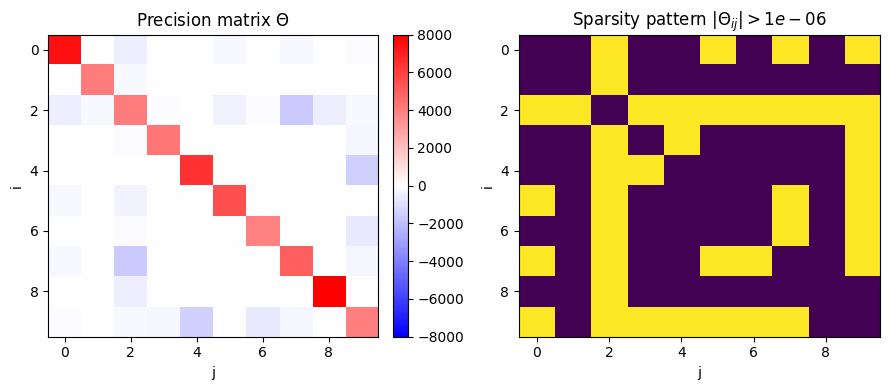

In [268]:
plot_precision_matrix(Theta)

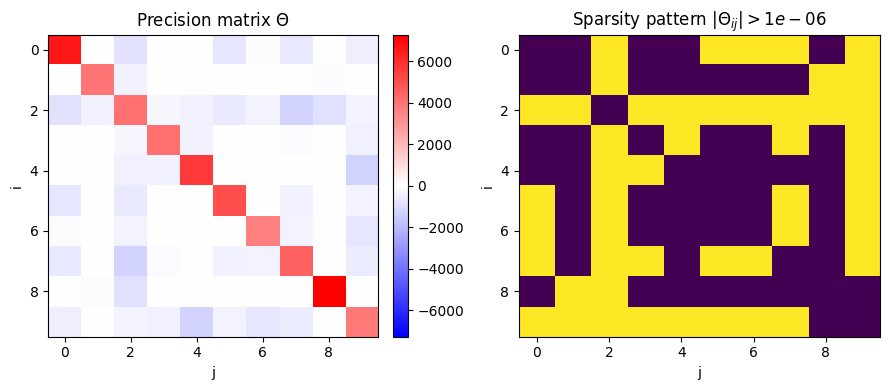

In [269]:
plot_precision_matrix(Theta_package)

#### **2. Parameter selection: Cross validation**
- Next, we ensure the cross validation is working well.
- To do it, we visualise the crossvalidation score for different lambdas.
- We also compare it with the results of the package verison.

In [271]:
lambdas = [1e-6 + 1e-6*i*5 for i in range(50)]

# Time-series safe folds:
folds = make_walk_forward_folds(len(X_train), n_splits=5)

#best_lam, cv_table = cv_select_lambda(
#    X_train, lambdas, folds
#)
#cv_table.to_excel('results/cv_table.xlsx')
cv_table = pd.read_excel('results/cv_table.xlsx')
best_lam = cv_table.loc[0, "lambda"]

from sklearn.covariance import GraphicalLassoCV
model = GraphicalLassoCV(alphas=lambdas, cv=5)
model.fit(X_train)

print("Best lambda(bench): ", model.alpha_)
print("Best avg number of edges (CV Based): ", cv_table.loc[0,"mean_edges"])
print("Best lambda:", best_lam)

Best lambda(bench):  1.1e-05
Best avg number of edges (CV Based):  1395.4
Best lambda: 1.1e-05


**Cross validation criteria**

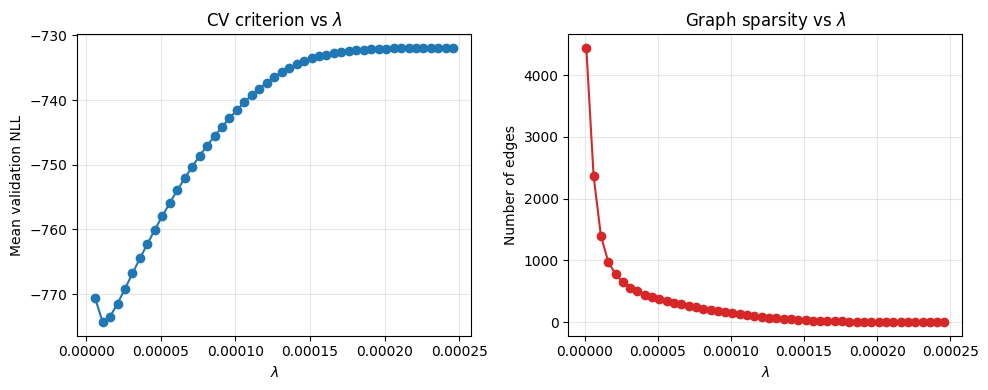

In [265]:
cv_table.sort_values('lambda',inplace=True)
lambdas = cv_table["lambda"].values
mean_nll = cv_table["mean_val_nll"].values
mean_edges = cv_table["mean_edges"].values

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# ---- Mean validation log-likelihood (or NLL) ----
axes[0].plot(lambdas, mean_nll, marker="o")
axes[0].set_xlabel(r"$\lambda$")
axes[0].set_ylabel("Mean validation NLL")
axes[0].set_title("CV criterion vs $\lambda$")
axes[0].grid(True, alpha=0.3)

# ---- Number of edges ----
axes[1].plot(lambdas, mean_edges, marker="o", color="tab:red")
axes[1].set_xlabel(r"$\lambda$")
axes[1].set_ylabel("Number of edges")
axes[1].set_title("Graph sparsity vs $\lambda$")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
out_path = "results/CV.png"
plt.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()

**Benchmark : cross validation criterion**

In [237]:
cv_table_bench = pd.DataFrame(model.cv_results_)
cv_table_bench.head()

,alphas,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score
0,0.000246,276.145143,275.704346,273.978403,272.738956,274.888842,274.691138,1.224648
1,0.000241,276.145143,275.704346,273.978403,272.738956,274.888842,274.691138,1.224648
2,0.000236,276.145834,275.704346,273.978403,272.738956,274.888842,274.691276,1.224812
3,0.000231,276.153395,275.704346,273.978403,272.738956,274.888842,274.692788,1.226610
4,0.000226,276.160855,275.713118,273.978403,272.738956,274.888842,274.696035,1.229836


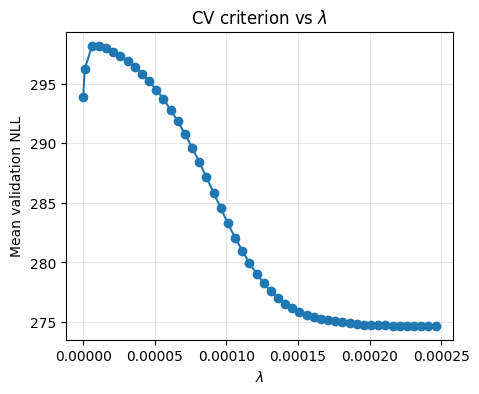

In [264]:
lambdas = cv_table_bench["alphas"].values
mean_nll = cv_table_bench["mean_test_score"].values

fig = plt.figure(figsize=(5, 4))

# ---- Mean validation log-likelihood (or NLL) ----
plt.plot(lambdas, mean_nll, marker="o")
plt.xlabel(r"$\lambda$")
plt.ylabel("Mean validation NLL")
plt.title("CV criterion vs $\lambda$")
plt.grid(True, alpha=0.3)

out_path = "results/bench_cv.png"
plt.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()

#### **3. Parameter selection: BIC**
-

In [259]:
lambdas = [1e-6 + 1e-6*i*5 for i in range(50)]
n = X.shape[0]

best_lam_bic, bic_df = select_lambda_bic(
    X=X_train,
    n=n,
    lambdas=lambdas,
    gamma=1
)
#bic_df.to_excel("results/bic_df.xlsx")
print("Best lambda (BIC):", best_lam_bic)
print("Best number of edges (BIC based):", bic_df.iloc[0]['edges'])

Best lambda (BIC): 2.1e-05
Best number of edges (BIC based): 637.0


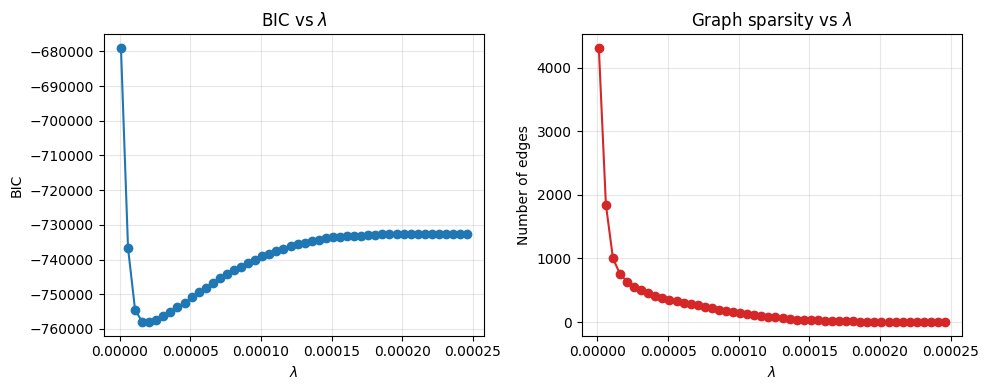

In [262]:
bic_df.sort_values('lambda',inplace=True)
lambdas = bic_df["lambda"].values
BIC = bic_df["BIC"].values
edges = bic_df["edges"].values

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# ---- Mean validation log-likelihood (or NLL) ----
axes[0].plot(lambdas, BIC, marker="o")
axes[0].set_xlabel(r"$\lambda$")
axes[0].set_ylabel("BIC")
axes[0].set_title("BIC vs $\lambda$")
axes[0].grid(True, alpha=0.3)

# ---- Number of edges ----
axes[1].plot(lambdas, edges, marker="o", color="tab:red")
axes[1].set_xlabel(r"$\lambda$")
axes[1].set_ylabel("Number of edges")
axes[1].set_title("Graph sparsity vs $\lambda$")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
out_path = "results/BIC.png"
plt.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()


# **IV. Results** 

#### Visualisation of the graph using manifold

In [356]:
S_train = np.cov(X, rowvar=False, bias=False)
Theta = graphical_lasso_from_cov(S_train,5e-5)
Sigma_hat = np.linalg.inv(Theta)

#### sector comparison

In [360]:
import pandas as pd

asset_map = pd.read_csv("data/map.csv")  # adjust path if needed
# try to standardize column names:
asset_map.columns = [c.lower() for c in asset_map.columns]

# adapt if your columns are named differently
asset_col = "asset"
sector_col = "sector"
assert asset_col in asset_map.columns and sector_col in asset_map.columns

sector_of = dict(zip(asset_map[asset_col].astype(str), asset_map[sector_col].astype(str)))

# For assets not found in map, set sector to None
sectors_aligned = [sector_of.get(str(a), None) for a in asset_cols]
missing = sum(s is None for s in sectors_aligned)
print("Missing sector labels for assets:", missing)


Missing sector labels for assets: 0


In [362]:
import numpy as np

def edge_counts_from_theta(Theta, asset_cols, sector_of, thr=1e-6):
    Theta = np.asarray(Theta)
    p = Theta.shape[0]
    assert p == len(asset_cols)

    # upper-triangular mask of edges (i<j)
    iu, ju = np.triu_indices(p, k=1)
    is_edge = np.abs(Theta[iu, ju]) > thr

    # assets + sectors for each edge candidate
    a_i = np.array([asset_cols[i] for i in iu])
    a_j = np.array([asset_cols[j] for j in ju])

    s_i = np.array([sector_of.get(str(a), None) for a in a_i], dtype=object)
    s_j = np.array([sector_of.get(str(a), None) for a in a_j], dtype=object)

    # keep only actual edges
    s_i = s_i[is_edge]
    s_j = s_j[is_edge]

    total = len(s_i)

    known = (s_i != None) & (s_j != None)
    within = np.sum((s_i == s_j) & known)
    cross  = np.sum((s_i != s_j) & known)
    unknown = total - (within + cross)

    within_share = within / (within + cross) if (within + cross) > 0 else np.nan

    return {
        "edges_total": int(total),
        "edges_within": int(within),
        "edges_cross": int(cross),
        "edges_unknown_sector": int(unknown),
        "within_share_excl_unknown": float(within_share),
    }


In [363]:
stats = edge_counts_from_theta(Theta, asset_cols, sector_of, thr=1e-6)
print(stats)


{'edges_total': 352, 'edges_within': 266, 'edges_cross': 86, 'edges_unknown_sector': 0, 'within_share_excl_unknown': 0.7556818181818182}


In [357]:
from sklearn import cluster

names = X_train_df.columns
_, labels = cluster.affinity_propagation(Sigma_hat, random_state=0)
n_labels = labels.max()

for i in range(n_labels + 1):
    print(f"Cluster {i + 1}: {', '.join(names[labels == i])}")

Cluster 1: A001, A002, A003, A006, A008, A009
Cluster 2: A004, A005, A007, A010
Cluster 3: A011, A012, A013, A017, A019, A020
Cluster 4: A014, A015, A016, A018, A095
Cluster 5: A022, A024, A026, A029
Cluster 6: A025, A027, A030
Cluster 7: A021, A023, A028
Cluster 8: A033, A034, A036
Cluster 9: A032, A035, A038
Cluster 10: A031, A037, A039, A040
Cluster 11: A041, A042, A043, A044, A045, A046, A047, A048, A049, A050
Cluster 12: A051, A054, A057, A060
Cluster 13: A052, A053, A055, A056, A058, A059
Cluster 14: A061, A062, A063, A064, A065, A066, A067, A068, A069, A070
Cluster 15: A072, A074, A077, A079
Cluster 16: A075, A078
Cluster 17: A071, A073, A076, A080
Cluster 18: A081, A087
Cluster 19: A082, A083, A084, A085, A086, A088, A089, A090
Cluster 20: A092, A096, A100
Cluster 21: A097, A099
Cluster 22: A091, A093, A094, A098


In [358]:
from sklearn import manifold
import igraph as ig

node_position_model = manifold.LocallyLinearEmbedding(
    n_components=2, eigen_solver="dense", n_neighbors=6
)

embedding = node_position_model.fit_transform(X.T).T

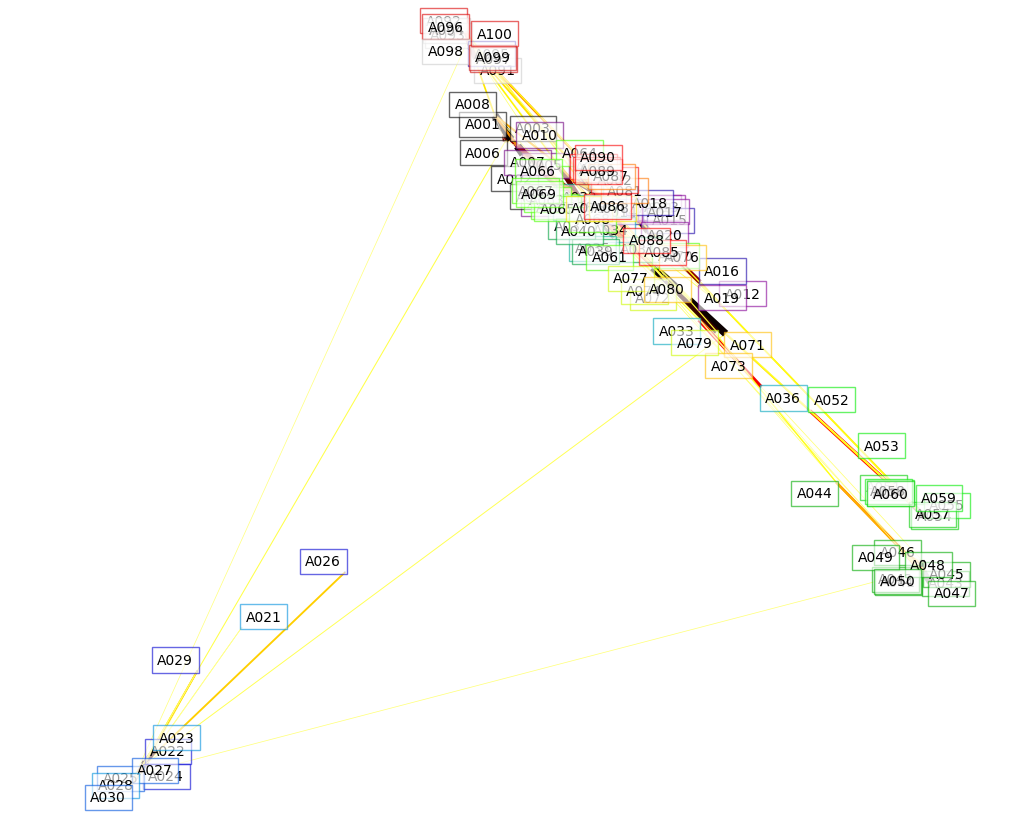

In [359]:

plt.figure(1, facecolor="w", figsize=(10, 8))
plt.clf()
ax = plt.axes([0.0, 0.0, 1.0, 1.0])
plt.axis("off")

# Plot the graph of partial correlations
partial_correlations = Theta.copy()
d = 1 / np.sqrt(np.diag(partial_correlations))
partial_correlations *= d
partial_correlations *= d[:, np.newaxis]
non_zero = np.abs(np.triu(partial_correlations, k=1)) > 0.02


# Plot the nodes using the coordinates of our embedding
plt.scatter(
    embedding[0], embedding[1], s=100 * d**2, c=labels, cmap=plt.cm.nipy_spectral
)

# Plot the edges
start_idx, end_idx = non_zero.nonzero()
# a sequence of (*line0*, *line1*, *line2*), where::
#            linen = (x0, y0), (x1, y1), ... (xm, ym)
segments = [
    [embedding[:, start], embedding[:, stop]] for start, stop in zip(start_idx, end_idx)
]
values = np.abs(partial_correlations[non_zero])
lc = LineCollection(
    segments, zorder=0, cmap=plt.cm.hot_r, norm=plt.Normalize(0, 0.7 * values.max())
)
lc.set_array(values)
lc.set_linewidths(15 * values)
ax.add_collection(lc)

# Add a label to each node. The challenge here is that we want to
# position the labels to avoid overlap with other labels
for index, (name, label, (x, y)) in enumerate(zip(names, labels, embedding.T)):
    dx = x - embedding[0]
    dx[index] = 1
    dy = y - embedding[1]
    dy[index] = 1
    this_dx = dx[np.argmin(np.abs(dy))]
    this_dy = dy[np.argmin(np.abs(dx))]
    if this_dx > 0:
        horizontalalignment = "left"
        x = x + 0.002
    else:
        horizontalalignment = "right"
        x = x - 0.002
    if this_dy > 0:
        verticalalignment = "bottom"
        y = y + 0.002
    else:
        verticalalignment = "top"
        y = y - 0.002
    plt.text(
        x,
        y,
        name,
        size=10,
        horizontalalignment=horizontalalignment,
        verticalalignment=verticalalignment,
        bbox=dict(
            facecolor="w",
            edgecolor=plt.cm.nipy_spectral(label / float(n_labels)),
            alpha=0.6,
        ),
    )

plt.xlim(
    embedding[0].min() - 0.15 * np.ptp(embedding[0]),
    embedding[0].max() + 0.10 * np.ptp(embedding[0]),
)
plt.ylim(
    embedding[1].min() - 0.03 * np.ptp(embedding[1]),
    embedding[1].max() + 0.03 * np.ptp(embedding[1]),
)

out_path = "results/graph_glasso.png"
plt.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()
